In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

#### Читаем оба временных ряда

In [3]:
df_nemo=pd.read_csv('./timelines_data/formed_timelines_2002/2002_spitz_nemo.csv', sep=';')
df_nemo['dates'] =  pd.to_datetime(df_nemo['dates'], format='%Y-%m-%d')
df_nemo['75.532663_17.902096_v']=df_nemo['75.532663_17.902096']-np.mean(df_nemo['75.532663_17.902096'])
df_nemo['76.006222_24.893752_v']=df_nemo['76.006222_24.893752']-np.mean(df_nemo['76.006222_24.893752'])
df_nemo['75.210923_11.252254_v']=df_nemo['75.210923_11.252254']-np.mean(df_nemo['75.210923_11.252254'])
df_rean=pd.read_csv('./timelines_data/formed_timelines_2002/2002_ARCTIC_reanalysis.csv', sep=';')
df_rean['dates'] =  pd.to_datetime(df_rean['dates'], format='%Y-%m-%d')
df_rean['75.532663_17.902096_v']=df_rean['75.532663_17.902096']-np.mean(df_rean['75.532663_17.902096'])
df_rean['76.006222_24.893752_v']=df_rean['76.006222_24.893752']-np.mean(df_rean['76.006222_24.893752'])
df_rean['75.210923_11.252254_v']=df_rean['75.210923_11.252254']-np.mean(df_rean['75.210923_11.252254'])

#### Вычитаем остатки там, где они незначимы

In [5]:
df_rean_list=[df_rean['75.210923_11.252254_v'], 
              df_rean['76.006222_24.893752_v'], 
              df_rean['75.532663_17.902096_v']]
df_nemo_list=[df_nemo['75.210923_11.252254_v'], 
              df_nemo['76.006222_24.893752_v'], 
              df_nemo['75.532663_17.902096_v']]

for i in range(len(df_rean_list)):

    stl_n = STL(df_nemo_list[i], period=80)
    res_n = stl_n.fit()
    stl_r = STL(df_rean_list[i], period=80)
    res_r = stl_r.fit()
    df_nemo[df_rean_list[i].name[:-2]+'_no_res']=df_nemo_list[i]-res_n.resid
    df_rean[df_rean_list[i].name[:-2]+'_no_res']=df_rean_list[i]-res_r.resid


### Делаем гибридную модель (среднее значение NEMO и ARIMA)

In [6]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

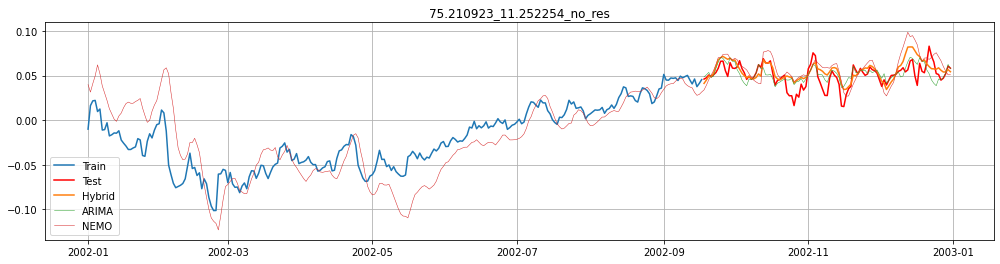

MSE =  0.00012688843295610453
MAE =  0.008559772856173235
MAPE =  21.881
R^2 =  0.2198222724394161


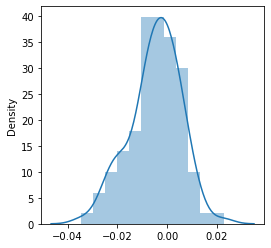

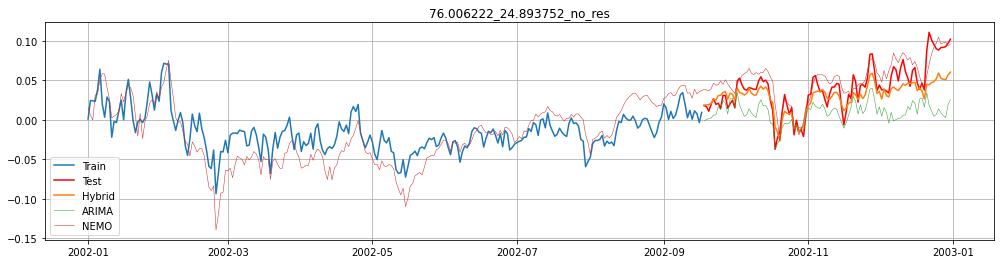

MSE =  0.0003486749538818053
MAE =  0.013768033074454124
MAPE =  5.036
R^2 =  0.5935886481891793


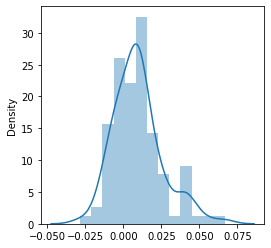

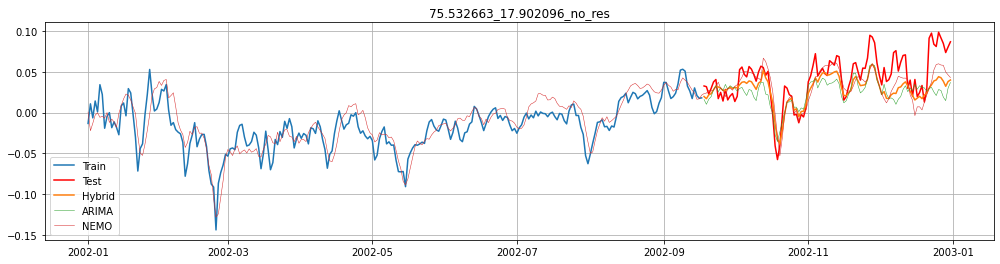

MSE =  0.0005255186684109225
MAE =  0.017752931716434
MAPE =  16.871
R^2 =  0.39131141687026194


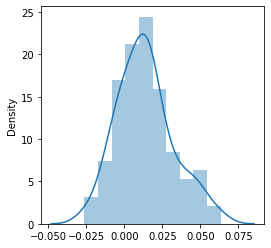

In [8]:
df_rean_list=[df_rean['75.210923_11.252254_no_res'], 
              df_rean['76.006222_24.893752_no_res'], 
              df_rean['75.532663_17.902096_no_res']]
df_nemo_list=[df_nemo['75.210923_11.252254_no_res'], 
              df_nemo['76.006222_24.893752_no_res'], 
              df_nemo['75.532663_17.902096_no_res']]

for i in range(len(df_rean_list)):
    
    test = df_rean_list[i][-105:]
    test.index = df_rean['dates'][-105:]
    data = df_rean_list[i][:-105]
    data.index = df_rean['dates'][:-105]
    
    nemo_pr=df_nemo_list[i][-105:]
    nemo_pr.index = df_nemo['dates'][-105:]

    stlf = STLForecast(data, ARIMA, period=80, model_kwargs={"order": (2, 1, 0)})
    model_res = stlf.fit()
    forecasts = model_res.forecast(105)
    
    hybrid_forecact=(nemo_pr+forecasts)/2
    
    plt.rcParams['figure.figsize'] = [17, 4]
    plt.plot(data, label='Train')
    plt.plot(test, c='r', label='Test')
    plt.plot(hybrid_forecact, label='Hybrid')
    plt.plot(forecasts, label='ARIMA', linewidth=0.5)
    plt.plot(df_nemo['dates'], df_nemo_list[i], label='NEMO', linewidth=0.5)
    
    plt.title(df_rean_list[i].name)
    plt.legend()
    plt.grid()
    plt.show()
    
    print("MSE = ", mean_squared_error(test, hybrid_forecact))
    print("MAE = ", mean_absolute_error(test, hybrid_forecact))
    print("MAPE = ", round(np.mean(np.abs(test-hybrid_forecact)/test)*100,3))
    print("R^2 = ", r2_score(test, hybrid_forecact))

    plt.rcParams['figure.figsize'] = [4, 4]
    sns.distplot(test-hybrid_forecact)
    plt.show()

### *В двух случаях из трех наблюдается улучшение метрик*

___
ВАРИАНТЫ СЛЕДУЮЩИХ ЭКСПЕРИМЕНТОВ:
___
1) Протестировать на других участках временного ряда (сезонах - не только на декабре)

2) Набрать больше точек и повторить моделирование (может на каких-то участках работает лучше, на каких-то хуже)